In [1]:
for (pkg in c("ggplot2", "dplyr", "patchwork", "ggplotify")) {
    suppressPackageStartupMessages(
        suppressWarnings(
            library(
                pkg,
                character.only = TRUE,
                quietly = TRUE,
                warn.conflicts = FALSE
            )
        )
    )
}
source("../../utils/r_themes.r")

In [2]:
actual_results_file_path <- file.path("../../data/CP_aggregated/endpoints/aggregated_profile.parquet")
actual_results <- arrow::read_parquet(actual_results_file_path)
actual_results$Metadata_Time <- 13
actual_results$shuffled <- "not_shuffled"

# prepend Terminal to each non metadata column name
actual_results <- actual_results %>%
  rename_with(~ paste0("Terminal_", .), -c(Metadata_Time, Metadata_dose, Metadata_Well, shuffled))

columns_to_keep <- colnames(actual_results)



results_file_path <- file.path("../results/all_terminal_features.parquet")
results <- arrow::read_parquet(results_file_path)

subset_results <- results[, colnames(results) %in% columns_to_keep]

In [3]:

# drop the singlecells, compound, and control columns
actual_results <- actual_results %>%
  select(-c(Terminal_Metadata_number_of_singlecells, Terminal_Metadata_plate, Terminal_Metadata_compound, Terminal_Metadata_control))

In [4]:

# merge the two dataframes on the columns "Metadata_Time" and "Metadata_dose" Metadata_Well
merged_results <- rbind(subset_results,actual_results )
merged_results$Metadata_Time <- as.numeric(merged_results$Metadata_Time) * 30
merged_results$Metadata_dose <- as.numeric(merged_results$Metadata_dose)
merged_results$Metadata_dose <- factor(
    merged_results$Metadata_dose, 
    levels = c(
        '0',
        '0.61',
        '1.22',
        '2.44',
        '4.88',
        '9.77',
        '19.53',
        '39.06',
        '78.13',
        '156.25'
    )
)


In [5]:
merged_results <- merged_results %>%
    arrange(Metadata_Well, Metadata_Time)

In [6]:

# map the train_test to the merged data
train_test_df <- results %>%
  select(Metadata_Well, Metadata_data_split) %>%
  distinct() %>%
  mutate(Metadata_data_split = gsub("train", "Train", Metadata_data_split)) %>%
  mutate(Metadata_data_split = gsub("test", "Test", Metadata_data_split))
# map the data split by well to the merged data

train_test_df <- train_test_df %>% distinct(Metadata_Well, .keep_all = TRUE)
# drop na 
train_test_df <- train_test_df %>%
  filter(!is.na(Metadata_Well)) %>%
  filter(!is.na(Metadata_data_split))
# join the train_test_df to the merged_results on the Metadata_Well column
merged_results <- merged_results %>%
  left_join(train_test_df, by = "Metadata_Well")

In [7]:

merged_results$Metadata_data_split <- gsub("non_Trained_pair", "Train", merged_results$Metadata_data_split)
merged_results$shuffled <- gsub("shuffled", "Shuffled", merged_results$shuffled)
merged_results$shuffled <- gsub("not_Shuffled", "Not shuffled", merged_results$shuffled)


In [8]:
# drop na
merged_results <- merged_results %>%
  filter(!is.na(Metadata_data_split)) %>%
  filter(!is.na(Metadata_Well)) %>%
  filter(!is.na(Metadata_Time)) %>%
  filter(!is.na(Metadata_dose))


In [9]:

merged_results <- merged_results %>% arrange(Metadata_Well, Metadata_Time)


In [10]:
# get the pca of the results
metadata_columns <- c("Metadata_Time", "Metadata_dose", "Metadata_Well", "shuffled", "Metadata_data_split")
# drop the metadata columns from the dataframe
pcadf <- merged_results[, !colnames(merged_results) %in% metadata_columns]
pcadf <- pcadf[, sapply(pcadf, is.numeric)]  # keep only numeric columns
pcadf <- pcadf[, apply(pcadf, 2, function(x) var(x, na.rm = TRUE) != 0)]

head(pcadf)

Terminal_Cytoplasm_AreaShape_Area,Terminal_Cytoplasm_AreaShape_Compactness,Terminal_Cytoplasm_AreaShape_Eccentricity,Terminal_Cytoplasm_AreaShape_Extent,Terminal_Cytoplasm_AreaShape_FormFactor,Terminal_Cytoplasm_AreaShape_MajorAxisLength,Terminal_Cytoplasm_AreaShape_MedianRadius,Terminal_Cytoplasm_AreaShape_MinFeretDiameter,Terminal_Cytoplasm_AreaShape_Orientation,Terminal_Cytoplasm_AreaShape_Perimeter,⋯,Terminal_Nuclei_Texture_Correlation_AnnexinV_3_00_256,Terminal_Nuclei_Texture_Correlation_AnnexinV_3_01_256,Terminal_Nuclei_Texture_Correlation_AnnexinV_3_02_256,Terminal_Nuclei_Texture_Correlation_AnnexinV_3_03_256,Terminal_Nuclei_Texture_Correlation_DNA_3_02_256,Terminal_Nuclei_Texture_DifferenceVariance_AnnexinV_3_01_256,Terminal_Nuclei_Texture_InverseDifferenceMoment_AnnexinV_3_03_256,Terminal_Nuclei_Texture_InverseDifferenceMoment_DNA_3_03_256,Terminal_Nuclei_Texture_SumAverage_AnnexinV_3_00_256,Terminal_Nuclei_Texture_SumAverage_DNA_3_01_256
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-0.2760859,-0.1420822,0.2366544,-0.21174194,-0.1219327,-0.2523864,-0.3957049,0.24924683,0.11755147,-0.2096947,⋯,-0.5093025,-0.5365366,-0.4403568,-0.6126019,0.5533324,-0.2833795,0.4023901,0.3160771,0.03354997,0.6883655
-0.2906410,-0.2693617,0.2366544,-0.09774379,-0.1361047,-0.2131060,-0.4219242,-0.09514793,0.12521138,-0.2560814,⋯,-0.3945108,-0.5276511,-0.3699979,-0.6071447,0.1618566,-0.1713045,0.4505652,0.4414666,0.01237675,0.3531454
-0.2760859,-0.1420822,0.2366544,-0.21174194,-0.1180414,-0.2523864,-0.3957049,0.22493624,0.11755147,-0.2096947,⋯,-0.5047735,-0.5365366,-0.4403568,-0.6154417,0.6347924,-0.2833795,0.4023901,0.3160771,0.03354997,0.7147091
-0.2231399,-0.2490043,0.2366544,-0.07801766,-0.1379552,-0.1809200,-0.2767578,-0.03077541,0.07090512,-0.1919871,⋯,-0.4519126,-0.5384685,-0.4289165,-0.6137668,0.2079100,-0.1878364,0.4410207,0.4567778,0.00886009,0.3223466
-0.2760859,-0.1420822,0.2366544,-0.21174194,-0.1170205,-0.2523864,-0.3957049,0.24245652,0.11755147,-0.2096947,⋯,-0.5093001,-0.5365366,-0.4403568,-0.6193115,0.6211630,-0.2833795,0.4023901,0.3160771,0.03354997,0.7193898
-0.2206355,-0.2543057,0.2366544,-0.06752930,-0.1382636,-0.1771583,-0.2566853,-0.02847020,0.06005876,-0.1856010,⋯,-0.4568813,-0.5364853,-0.4302194,-0.6148705,0.1933145,-0.1700400,0.4481812,0.4564374,0.00827398,0.3380503


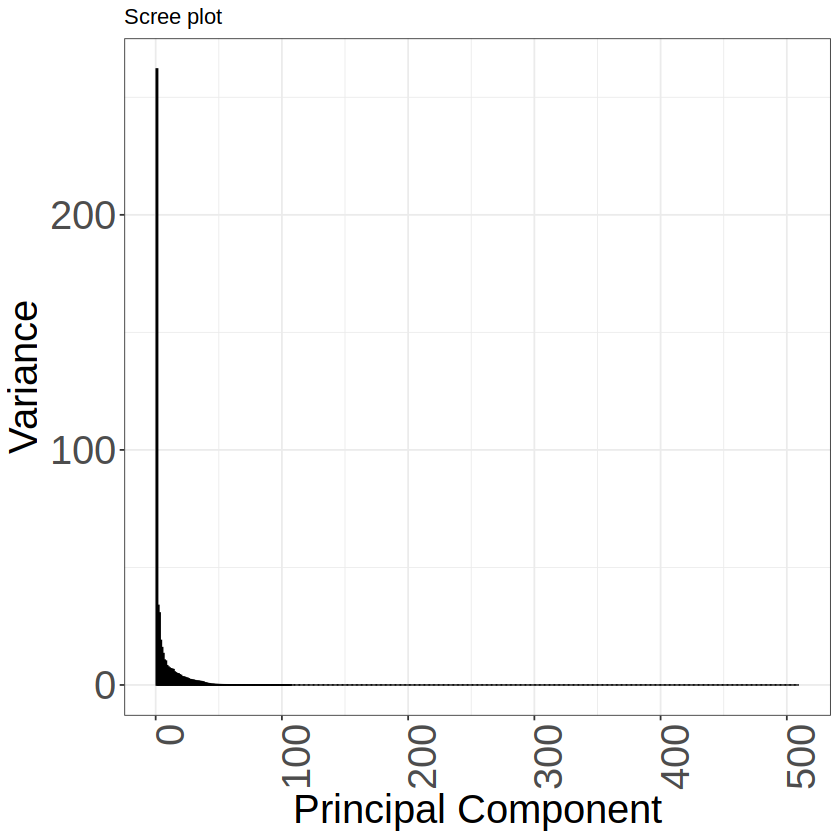

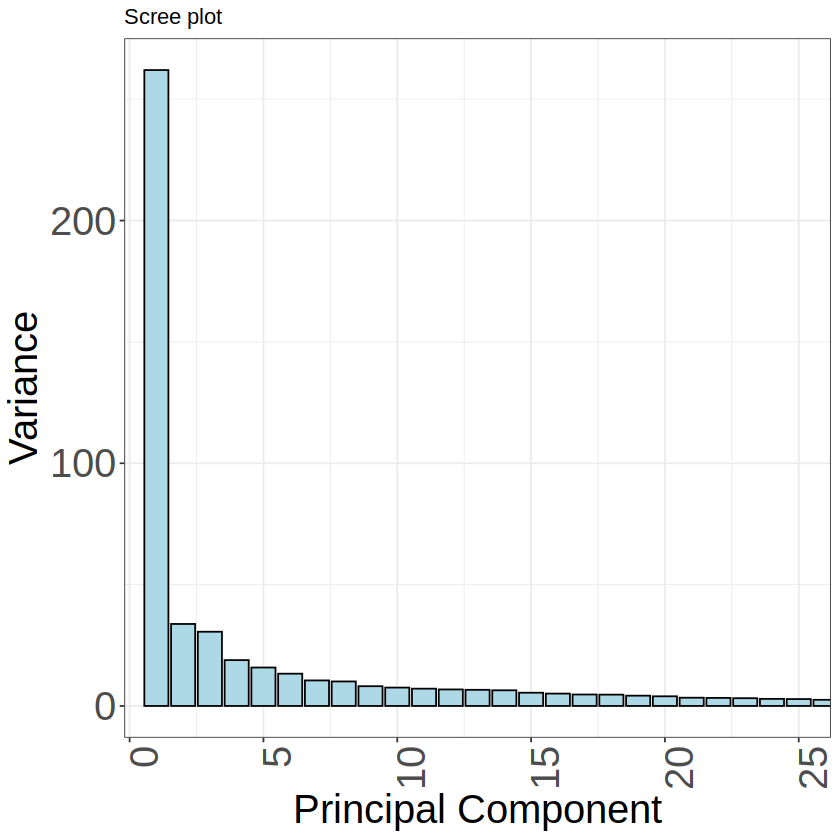

In [11]:
# scree plot to see how many components to keep
pca <- prcomp(pcadf, center = TRUE, rank. = 2, scale. = TRUE)
scree_data <- data.frame(
    PC = 1:length(pca$sdev),
    Variance = (pca$sdev)^2,
    Proportion = (pca$sdev)^2 / sum((pca$sdev)^2)
)
scree_plot <- (
    ggplot(scree_data, aes(x = PC, y = Variance, group = 1))
    + geom_bar(stat = "identity", fill = "lightblue", color = "black")
    + plot_themes
    + labs(
        title = "Scree plot",
        x = "Principal Component",
        y = "Variance"
    )
    + theme(
        axis.text.x = element_text(angle = 90, hjust = 1)
    )
)
scree_plot
# zoom in on the first 25 components
scree_plot_zoom <- (
    scree_plot
    + coord_cartesian(xlim = c(1, 25))
)
scree_plot_zoom

In [12]:

pca <- prcomp(pcadf, center = TRUE, rank. = 2, scale. = TRUE)
# get the pca of the results
pca_df <- data.frame(pca$x)
pca_df$Metadata_Time <- merged_results$Metadata_Time
pca_df$Metadata_dose <- merged_results$Metadata_dose
pca_df$Metadata_Well <- merged_results$Metadata_Well
pca_df$Metadata_data_split <- merged_results$Metadata_data_split
pca_df$shuffled <- merged_results$shuffled
pca_df$Metadata_Time <- as.double((pca_df$Metadata_Time))
pca_df$Metadata_dose <- as.factor(pca_df$Metadata_dose)

pca_df$PC1 <- as.numeric(pca_df$PC1)
pca_df <- pca_df %>%
  mutate(Group = Metadata_Well) %>%
  arrange(Metadata_Well, Metadata_Time)
pca_df <- pca_df %>%
  arrange(Metadata_Well, Metadata_Time)
head(pca_df)

,PC1,PC2,Metadata_Time,Metadata_dose,Metadata_Well,Metadata_data_split,shuffled,Group
,<dbl>,<dbl>,<dbl>,<fct>,<chr>,<chr>,<chr>,<chr>
1,-3.423994,-2.721879,0,0,C-02,Train,Shuffled,C-02
2,3.063069,2.794776,0,0,C-02,Train,Not shuffled,C-02
3,-3.019701,-4.520771,30,0,C-02,Train,Shuffled,C-02
4,10.491893,2.204092,30,0,C-02,Train,Not shuffled,C-02
5,-2.971541,-4.756352,60,0,C-02,Train,Shuffled,C-02
6,12.119099,2.115325,60,0,C-02,Train,Not shuffled,C-02


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


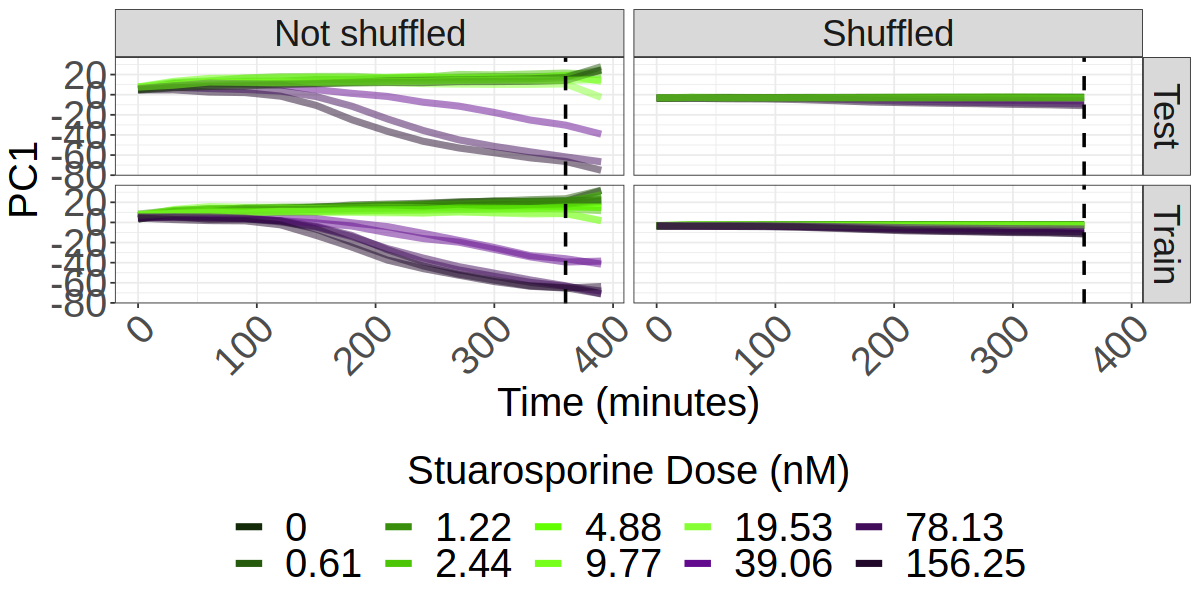

In [13]:
width <- 10
height <- 5
options(repr.plot.width=width, repr.plot.height=height)
# plot the pca
pca1_plot <- (
    ggplot(pca_df, aes(x = Metadata_Time, y = PC1, color = Metadata_dose, group = Group))
    + geom_line(aes(group = Group), alpha = 0.5, size = 2)
    + theme_minimal() 
    + facet_grid(Metadata_data_split ~ shuffled)
    + geom_vline(xintercept = (30*12), linetype = "dashed", color = "black", size = 1)
    + labs(x="Time (minutes)", y="PC1", color="Stuarosporine Dose (nM)")
    + plot_themes
    + scale_color_manual(values = color_palette_dose)
    + dose_guides_color
    + theme(
        # axis tick labels
        axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1),
    )

)
ggsave(
    filename = "../figures/predicted_PC1.png",
    plot = pca1_plot,
    width = width,
    height = height,
    dpi = 600
)
pca1_plot

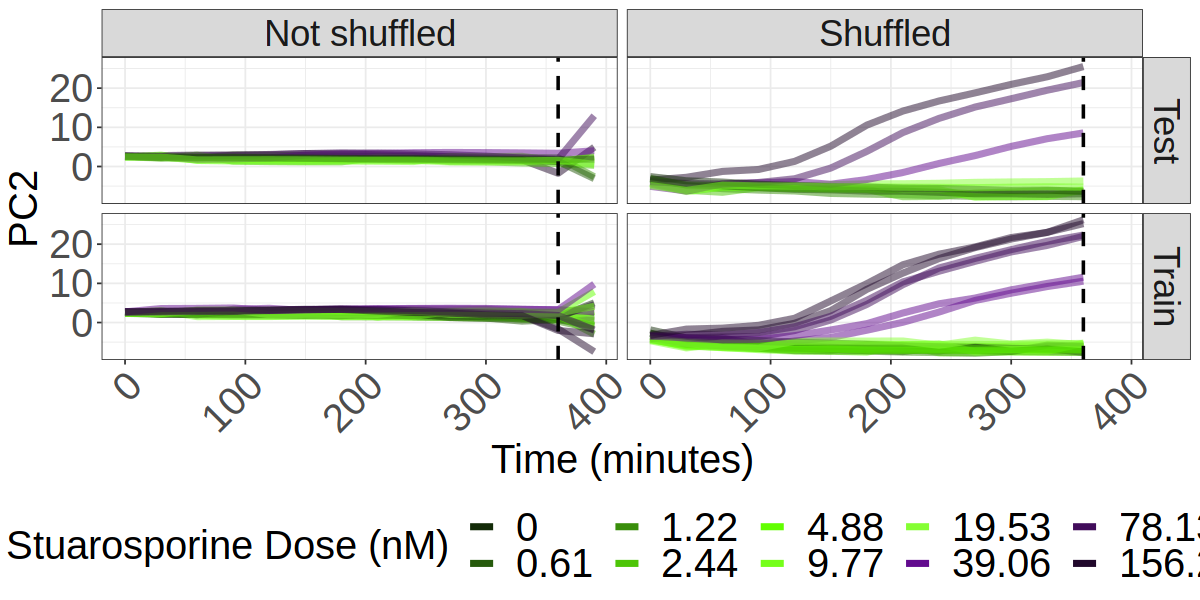

In [14]:
width <- 10
height <- 5
options(repr.plot.width=width, repr.plot.height=height)
# plot the pca
pca2_plot <- (
    ggplot(pca_df, aes(x = Metadata_Time, y = PC2, color = Metadata_dose, group = Group))
    + geom_line(aes(group = Group), alpha = 0.5, size = 2)
    + theme_minimal() 
    + facet_grid(Metadata_data_split ~ shuffled)
    + geom_vline(xintercept = (30*12), linetype = "dashed", color = "black", size = 1)
    + labs(x="Time (minutes)", y="PC2", color="Stuarosporine Dose (nM)")
    + plot_themes
    + scale_color_manual(values = color_palette_dose)
    + guides(color = guide_legend( override.aes = list(size = 5, alpha = 1)))
    + theme(
        # axis tick labels
        axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1),
    )

)
ggsave(
    filename = "../figures/predicted_PC2.png",
    plot = pca2_plot,
    width = width,
    height = height,
    dpi = 600
)
pca2_plot

In [15]:
pca_df$Metadata_shuffle_plus_data_split <- paste0(pca_df$shuffled, "\n", pca_df$Metadata_data_split)
pca_df$Metadata_Time <- paste0(pca_df$Metadata_Time, " min.")

pca_df$Metadata_Time <- factor(
    pca_df$Metadata_Time, 
    levels = c(
        '0 min.',
        '30 min.',
        '60 min.',
        '90 min.',
        '120 min.',
        '150 min.',
        '180 min.',
        '210 min.',
        '240 min.',
        '270 min.',
        '300 min.',
        '330 min.',
        '360 min.',
        '390 min.'
    )
)

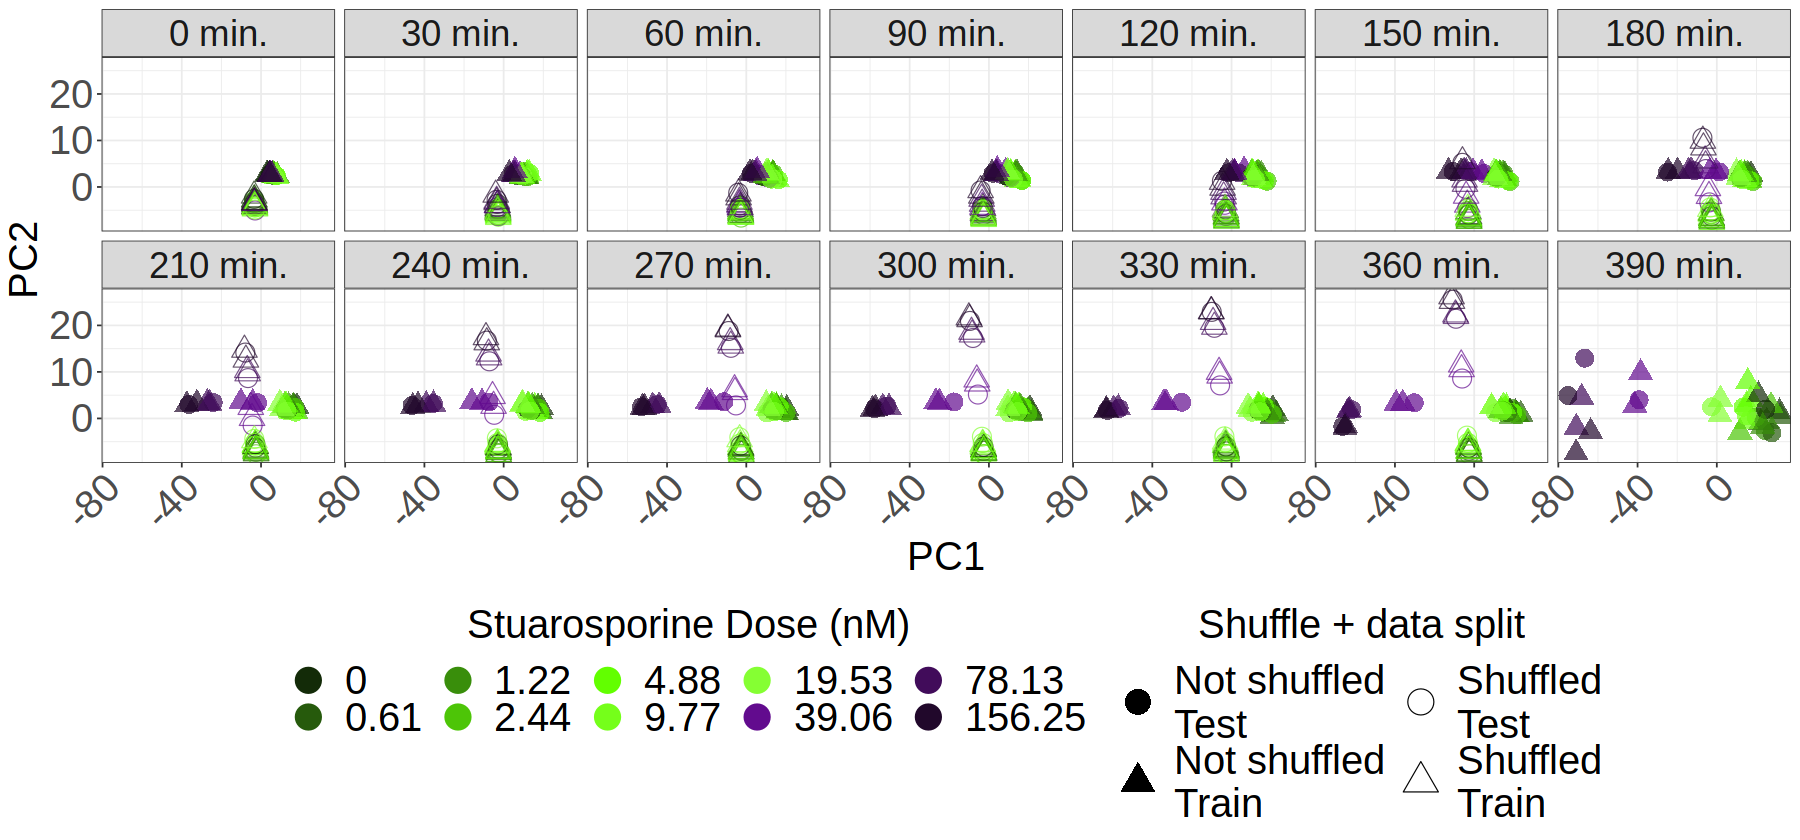

In [16]:
# plot PCA1 vs PCA2 over time
width <- 15
height <- 7
options(repr.plot.width=width, repr.plot.height=height)
pca_over_time_plot <- (
    ggplot(pca_df, aes(x = PC1, y = PC2, color = Metadata_dose))
    + geom_point(aes(shape = Metadata_shuffle_plus_data_split), size = 5, alpha = 0.7)
    + theme_minimal() 
    + facet_wrap( ~ Metadata_Time, ncol = 7)
    + labs(x="PC1", y="PC2", color="Stuarosporine Dose (nM)")
    + plot_themes
    + scale_color_manual(values = color_palette_dose)
    + scale_shape_manual(values = c(16, 17, 1, 2), name = "Shuffle + data split")
    
    + dose_guides_color
    + shuffle_guides_shape
    # spread the x axis ticks out 
    + scale_x_continuous(breaks = seq(-80, 20,by = 40))
    + theme(
        # axis tick labels
        axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1),
    )


)
ggsave(
    filename = "../figures/pca_over_time.png",
    plot = pca_over_time_plot,
    width = width,
    height = height,
    dpi = 600
)
pca_over_time_plot

In [17]:

merged_results <- merged_results %>%
  mutate(Group = Metadata_Well) %>%
  arrange(Metadata_Well, Metadata_Time)
merged_results <- merged_results %>% arrange(Group)
head(merged_results)

Terminal_Cytoplasm_AreaShape_Area,Terminal_Cytoplasm_AreaShape_Compactness,Terminal_Cytoplasm_AreaShape_Eccentricity,Terminal_Cytoplasm_AreaShape_Extent,Terminal_Cytoplasm_AreaShape_FormFactor,Terminal_Cytoplasm_AreaShape_MajorAxisLength,Terminal_Cytoplasm_AreaShape_MedianRadius,Terminal_Cytoplasm_AreaShape_MinFeretDiameter,Terminal_Cytoplasm_AreaShape_Orientation,Terminal_Cytoplasm_AreaShape_Perimeter,⋯,Terminal_Nuclei_Texture_InverseDifferenceMoment_AnnexinV_3_03_256,Terminal_Nuclei_Texture_InverseDifferenceMoment_DNA_3_03_256,Terminal_Nuclei_Texture_SumAverage_AnnexinV_3_00_256,Terminal_Nuclei_Texture_SumAverage_DNA_3_01_256,Metadata_Well,Metadata_Time,Metadata_dose,shuffled,Metadata_data_split,Group
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<fct>,<chr>,<chr>,<chr>
-0.2760859,-0.1420822,0.2366544,-0.21174194,-0.1219327,-0.2523864,-0.3957049,0.24924683,0.11755147,-0.2096947,⋯,0.4023901,0.3160771,0.03354997,0.6883655,C-02,0,0,Shuffled,Train,C-02
-0.2906410,-0.2693617,0.2366544,-0.09774379,-0.1361047,-0.2131060,-0.4219242,-0.09514793,0.12521138,-0.2560814,⋯,0.4505652,0.4414666,0.01237675,0.3531454,C-02,0,0,Not shuffled,Train,C-02
-0.2760859,-0.1420822,0.2366544,-0.21174194,-0.1180414,-0.2523864,-0.3957049,0.22493624,0.11755147,-0.2096947,⋯,0.4023901,0.3160771,0.03354997,0.7147091,C-02,30,0,Shuffled,Train,C-02
-0.2231399,-0.2490043,0.2366544,-0.07801766,-0.1379552,-0.1809200,-0.2767578,-0.03077541,0.07090512,-0.1919871,⋯,0.4410207,0.4567778,0.00886009,0.3223466,C-02,30,0,Not shuffled,Train,C-02
-0.2760859,-0.1420822,0.2366544,-0.21174194,-0.1170205,-0.2523864,-0.3957049,0.24245652,0.11755147,-0.2096947,⋯,0.4023901,0.3160771,0.03354997,0.7193898,C-02,60,0,Shuffled,Train,C-02
-0.2206355,-0.2543057,0.2366544,-0.06752930,-0.1382636,-0.1771583,-0.2566853,-0.02847020,0.06005876,-0.1856010,⋯,0.4481812,0.4564374,0.00827398,0.3380503,C-02,60,0,Not shuffled,Train,C-02


In [18]:
# single feature predictions
Terminal_Cytoplasm_Intensity_IntegratedIntensity_AnnexinV_path <- file.path(
    "../results/Terminal_Cytoplasm_Intensity_IntegratedIntensity_AnnexinV.parquet"
)

Terminal_Cytoplasm_Intensity_IntegratedIntensity_AnnexinV <- arrow::read_parquet(Terminal_Cytoplasm_Intensity_IntegratedIntensity_AnnexinV_path)


In [19]:
metadata_columns <- c("Metadata_Time", "Metadata_dose", "Metadata_Well", "shuffled", "Metadata_data_split")

In [20]:
subset_results_Terminal_Cytoplasm_Intensity_IntegratedIntensity_AnnexinV <- subset_results[, colnames(subset_results) %in% c("Terminal_Cytoplasm_Intensity_IntegratedIntensity_AnnexinV", metadata_columns)]
Terminal_Cytoplasm_Intensity_IntegratedIntensity_AnnexinV <- actual_results[, colnames(actual_results) %in% c("Terminal_Cytoplasm_Intensity_IntegratedIntensity_AnnexinV", metadata_columns)]


In [21]:

# merge the two dataframes on the columns "Metadata_Time" and "Metadata_dose" Metadata_Well
subset_results_Terminal_Cytoplasm_Intensity_IntegratedIntensity_AnnexinV <- rbind(
    subset_results_Terminal_Cytoplasm_Intensity_IntegratedIntensity_AnnexinV, 
    Terminal_Cytoplasm_Intensity_IntegratedIntensity_AnnexinV 
    )



In [22]:

subset_results_Terminal_Cytoplasm_Intensity_IntegratedIntensity_AnnexinV$Metadata_dose <- as.numeric(subset_results_Terminal_Cytoplasm_Intensity_IntegratedIntensity_AnnexinV$Metadata_dose)
subset_results_Terminal_Cytoplasm_Intensity_IntegratedIntensity_AnnexinV$Metadata_dose <- factor(
    subset_results_Terminal_Cytoplasm_Intensity_IntegratedIntensity_AnnexinV$Metadata_dose, 
    levels = c(
        '0',
        '0.61',
        '1.22',
        '2.44',
        '4.88',
        '9.77',
        '19.53',
        '39.06',
        '78.13',
        '156.25'
    )
)


In [23]:
head(subset_results_Terminal_Cytoplasm_Intensity_IntegratedIntensity_AnnexinV)

# merged_results$Metadata_dose <- gsub('0', '0.0', merged_results$Metadata_dose)
unique(subset_results_Terminal_Cytoplasm_Intensity_IntegratedIntensity_AnnexinV$Metadata_dose)
subset_results_Terminal_Cytoplasm_Intensity_IntegratedIntensity_AnnexinV <- subset_results_Terminal_Cytoplasm_Intensity_IntegratedIntensity_AnnexinV %>%
  mutate(Group = Metadata_Well) %>%
  arrange(Metadata_Well, Metadata_Time)
  


Terminal_Cytoplasm_Intensity_IntegratedIntensity_AnnexinV,Metadata_Well,Metadata_Time,Metadata_dose,shuffled
<dbl>,<chr>,<dbl>,<fct>,<chr>
-0.2224601,C-02,0,0,shuffled
-0.2224601,C-02,1,0,shuffled
-0.2224601,C-02,10,0,shuffled
-0.2224601,C-02,11,0,shuffled
-0.2224601,C-02,12,0,shuffled
-0.2224601,C-02,2,0,shuffled


[1] 0      0.61   1.22   2.44   4.88   9.77   19.53  39.06  78.13  156.25
Levels: 0 0.61 1.22 2.44 4.88 9.77 19.53 39.06 78.13 156.25

In [24]:
subset_results_Terminal_Cytoplasm_Intensity_IntegratedIntensity_AnnexinV <- subset_results_Terminal_Cytoplasm_Intensity_IntegratedIntensity_AnnexinV %>% arrange(Group)
subset_results_Terminal_Cytoplasm_Intensity_IntegratedIntensity_AnnexinV$Metadata_Time <- as.numeric(subset_results_Terminal_Cytoplasm_Intensity_IntegratedIntensity_AnnexinV$Metadata_Time) * 30


In [25]:

# add the data split
subset_results_Terminal_Cytoplasm_Intensity_IntegratedIntensity_AnnexinV <- subset_results_Terminal_Cytoplasm_Intensity_IntegratedIntensity_AnnexinV %>%
  left_join(train_test_df, by = "Metadata_Well")

In [26]:

subset_results_Terminal_Cytoplasm_Intensity_IntegratedIntensity_AnnexinV <- subset_results_Terminal_Cytoplasm_Intensity_IntegratedIntensity_AnnexinV %>%
  mutate(Metadata_data_split = gsub("non_trained_pair", "train", Metadata_data_split))

In [27]:
# change the dose to a factor
subset_results_Terminal_Cytoplasm_Intensity_IntegratedIntensity_AnnexinV$Metadata_dose <- as.factor(subset_results_Terminal_Cytoplasm_Intensity_IntegratedIntensity_AnnexinV$Metadata_dose)

In [28]:
# drop na in the data split column
subset_results_Terminal_Cytoplasm_Intensity_IntegratedIntensity_AnnexinV <- subset_results_Terminal_Cytoplasm_Intensity_IntegratedIntensity_AnnexinV %>%
  filter(!is.na(Metadata_data_split)) %>%
  filter(!is.na(Metadata_Well)) %>%
  filter(!is.na(Metadata_Time)) %>%
  filter(!is.na(Metadata_dose))

subset_results_Terminal_Cytoplasm_Intensity_IntegratedIntensity_AnnexinV$Metadata_data_split <- gsub("non_Trained_pair", "Train", subset_results_Terminal_Cytoplasm_Intensity_IntegratedIntensity_AnnexinV$Metadata_data_split)
subset_results_Terminal_Cytoplasm_Intensity_IntegratedIntensity_AnnexinV$shuffled <- gsub("shuffled", "Shuffled", subset_results_Terminal_Cytoplasm_Intensity_IntegratedIntensity_AnnexinV$shuffled)

subset_results_Terminal_Cytoplasm_Intensity_IntegratedIntensity_AnnexinV$shuffled <- gsub("not_Shuffled", "Not shuffled", subset_results_Terminal_Cytoplasm_Intensity_IntegratedIntensity_AnnexinV$shuffled)


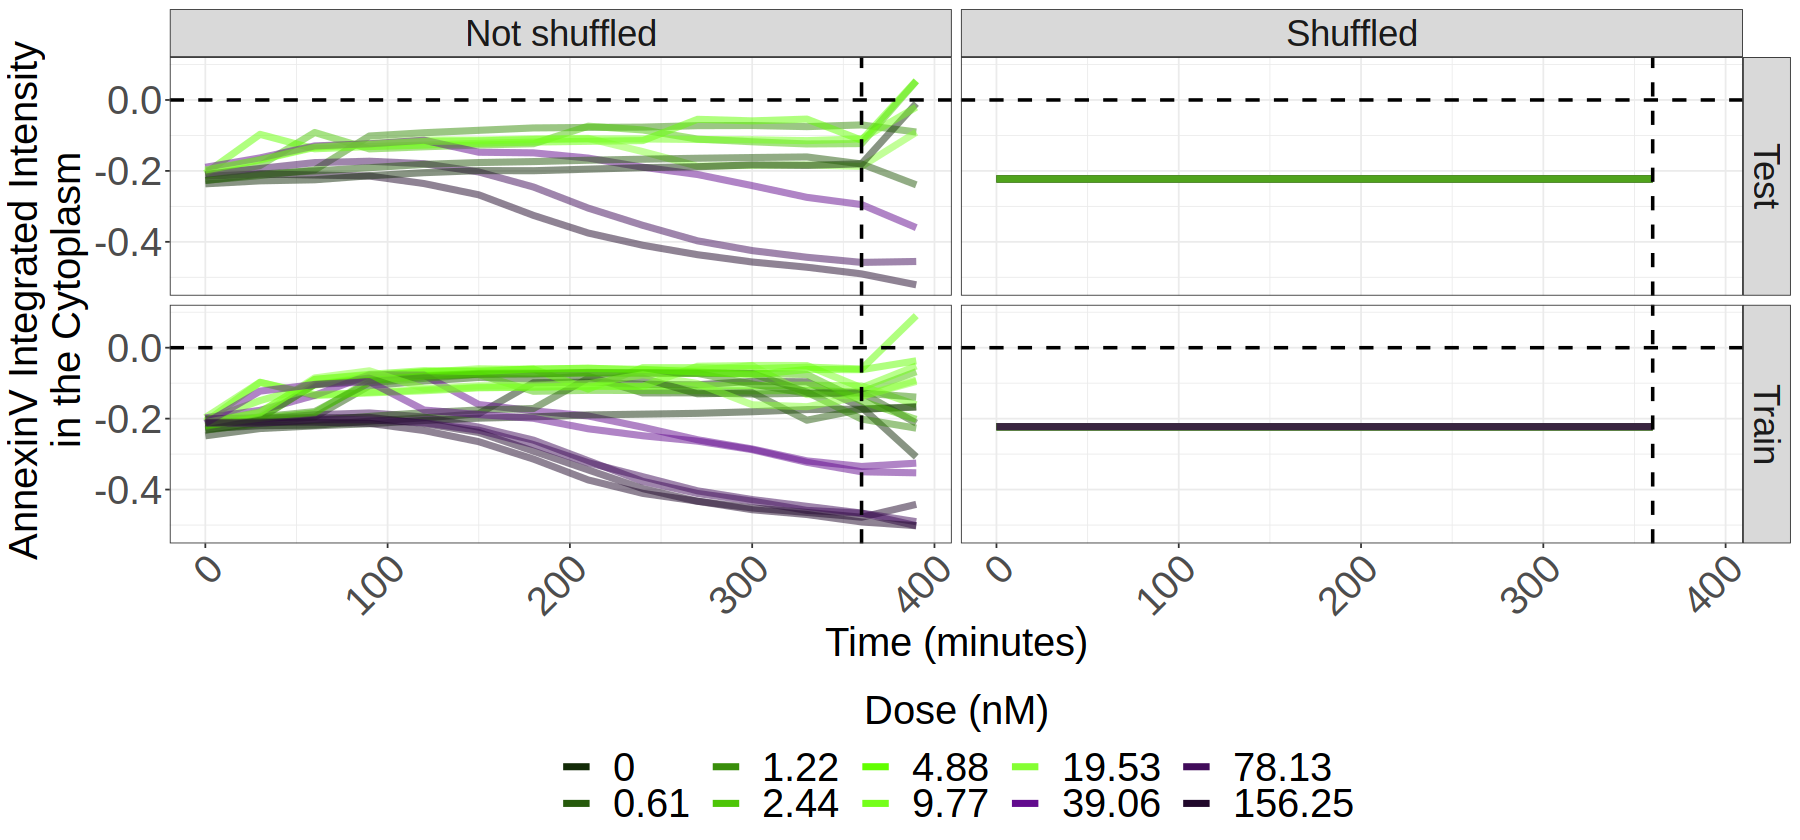

In [29]:
# plot the pca
Terminal_Cytoplasm_Intensity_IntegratedIntensity_AnnexinV_plot <- (
    ggplot(subset_results_Terminal_Cytoplasm_Intensity_IntegratedIntensity_AnnexinV, aes(x = Metadata_Time, y = Terminal_Cytoplasm_Intensity_IntegratedIntensity_AnnexinV, color = Metadata_dose, group = Group))
    + geom_line(aes(group = Group), alpha = 0.5, size = 2)
    + theme_minimal() 
    + facet_grid(Metadata_data_split ~ shuffled)

    + geom_vline(xintercept = (30*12), linetype = "dashed", color = "black", size = 1)
    + geom_hline(yintercept = 0, linetype = "dashed", color = "black", size = 1)

    + labs(x="Time (minutes)", y="AnnexinV Integrated Intensity\nin the Cytoplasm", color="Dose (nM)")
    + plot_themes
    + scale_color_manual(values = color_palette_dose)
    + dose_guides_color
    + theme(
        # axis tick labels
        axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1),
    )


)
ggsave(
    filename = "../figures/AnnexinV_Integrated_Intensity_in_the_Cytoplasm.png",
    plot = Terminal_Cytoplasm_Intensity_IntegratedIntensity_AnnexinV_plot,
    width = width,
    height = height,
    dpi = 600
)
Terminal_Cytoplasm_Intensity_IntegratedIntensity_AnnexinV_plot

### Workflow figure

In [30]:
# read and rasterize the workflow figure
workflow_figure_path <- file.path(
    "../external_images/timelapse_apoptosis_ML_strategy_figure.png"
)
workflow_figure <- png::readPNG(workflow_figure_path)
workflow_figure_raster <- grid::rasterGrob(workflow_figure, interpolate = TRUE)
workflow_figure_raster <- as.ggplot(
    workflow_figure_raster
) + 
    theme_void() +
    theme(
        plot.margin = margin(0, 0, 0, 0)
    )
# cut down on the whitespace around the image
workflow_figure_raster <- workflow_figure_raster + 
    theme(
        plot.margin = margin(0, 0, -1, -1) # left, right, top, bottom
    )

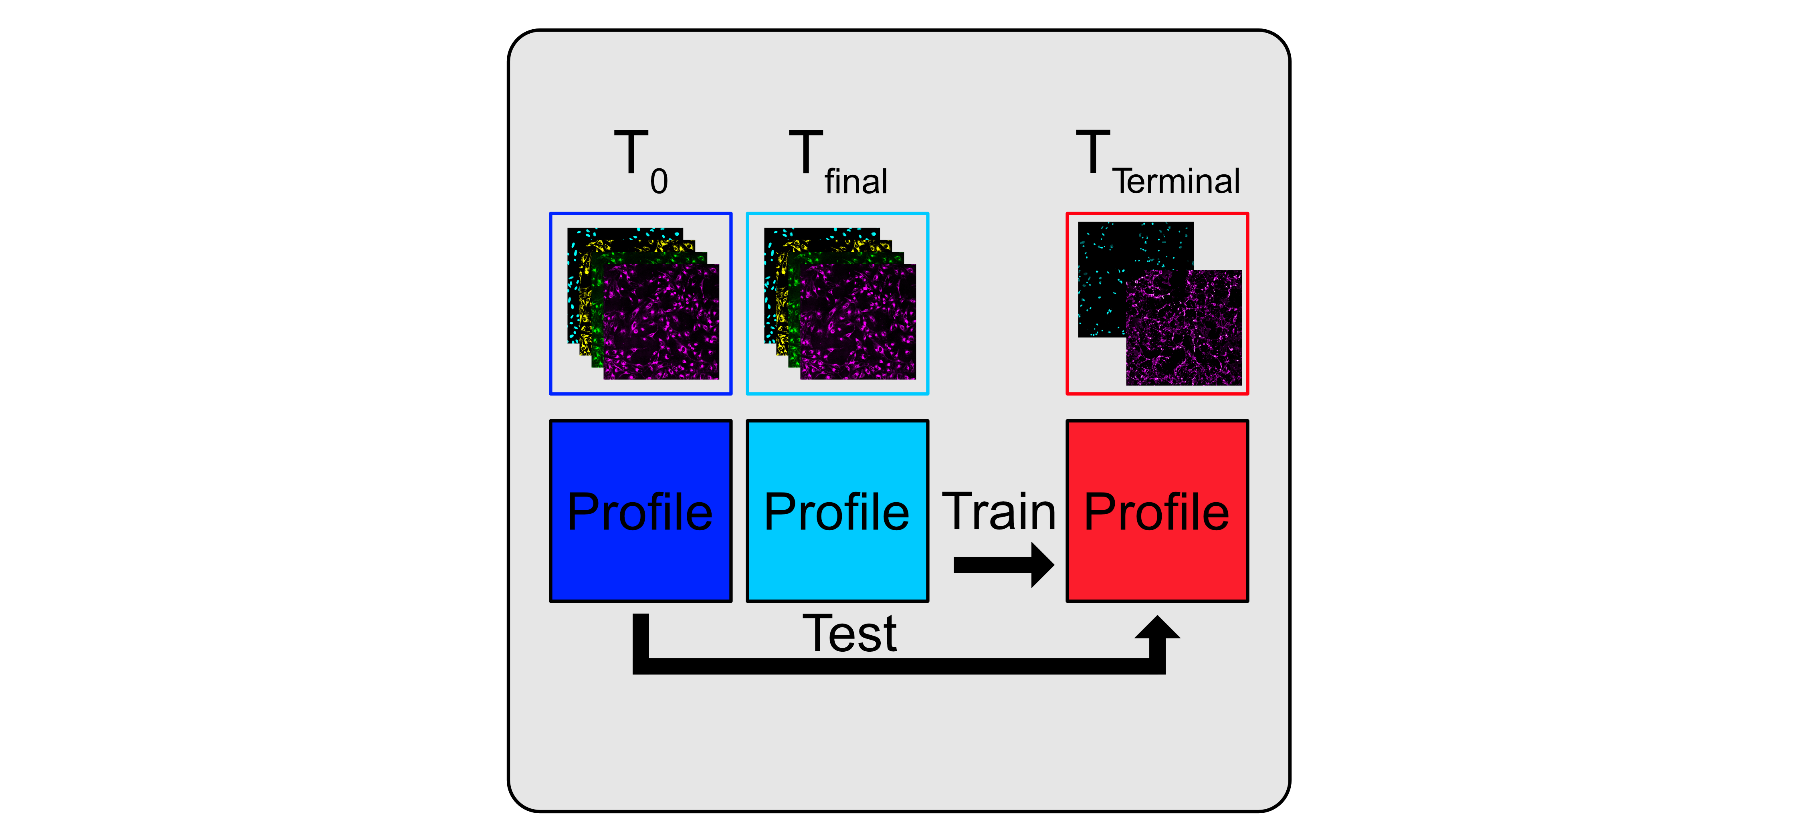

In [31]:
workflow_figure_raster

### Patchwork for a final figure

In [32]:
Terminal_Cytoplasm_Intensity_IntegratedIntensity_AnnexinV_plot <- Terminal_Cytoplasm_Intensity_IntegratedIntensity_AnnexinV_plot + theme(legend.position = "none")
pca1_plot <- pca1_plot + theme(legend.position = "none")

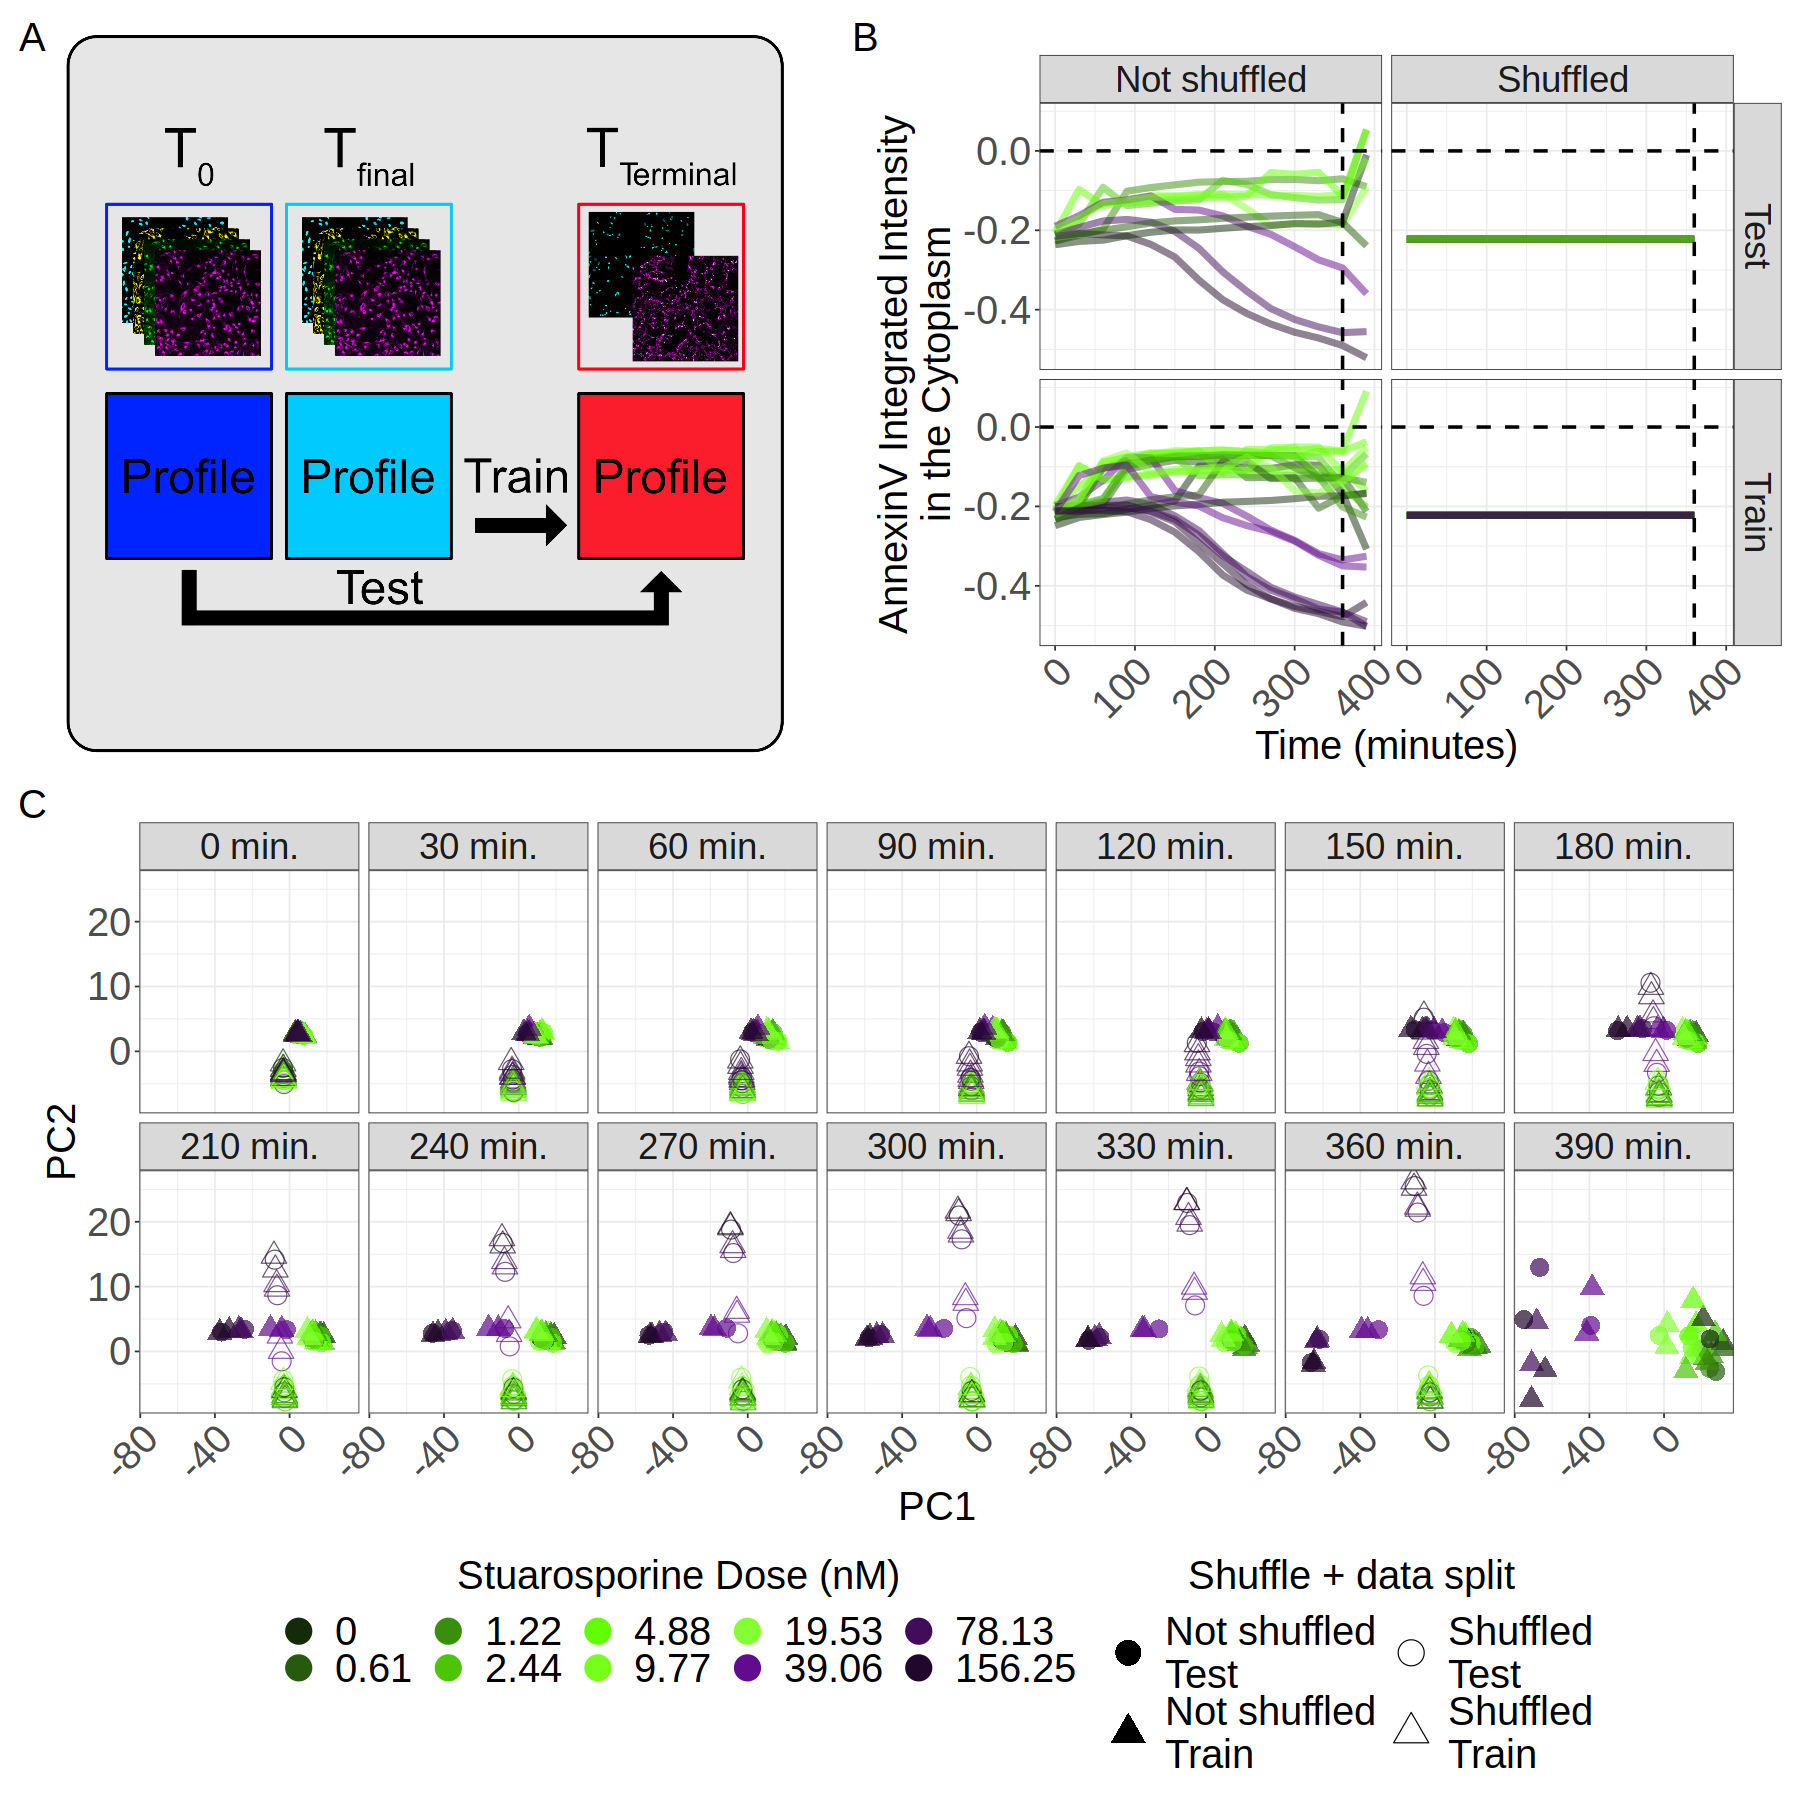

In [33]:
layout <- "
AABB
CCCC
"
height <- 15
width <- 15
options(repr.plot.width=width, repr.plot.height=height)
final_plot <- (
    # workflow_figure_raster
    # tight layout
    wrap_elements(
        full = workflow_figure_raster
    )
    + Terminal_Cytoplasm_Intensity_IntegratedIntensity_AnnexinV_plot 
     
    + pca_over_time_plot
    + plot_layout(design = layout)
    + plot_annotation(tag_levels = 'A') & theme(plot.tag = element_text(size = 24))
)
ggsave(
    filename = "../figures/final_predicted_terminal_profiles_from_all_time_points.png",
    plot = final_plot,
    width = width,
    height = height,
    dpi = 600
)
final_plot